# Claims — Closed Summary & Open Aging Pareto (v2)
Generated: 2025-11-05 19:16:32

This notebook:
- Lets you pick **warehouses**, **date range** and **max labels**.
- Builds a **Closed Claims** summary (count, mean, median, min, max days to close).
- Builds **Open Claims Aging** buckets and makes a **Pareto** (bar + cumulative %) per warehouse.
- **Merges both files** into one **combined DataFrame** with **all original columns**, plus standardized columns appended.
- Exports to `claims_analysis_output.xlsx` with three sheets:
  - `All_Claims_Combined` (merged; filtered to selected warehouses/date)
  - `Closed_Claims_Summary`
  - `Open_Claims_Aging`

**Definitions**
- **Closed** = `Completed Date` **present**
- **Open** = `Completed Date` **blank**
- **Days to close** = `Completed Date - Start Date` (calendar days)
- **Aging buckets** for open claims: `<30`, `30–<60`, `60–<90`, `≥90`

In [19]:
# ==== Parameters (edit these) ====
warehouses = ["OKC", "Atlanta", "Orlando", "Ontario", "El Paso", "Flowood", "Phoenix", "Charlotte"]

# Date window applied to Start Date. Set None to disable either bound.
start_date = "2024-01-01"   # e.g., "2024-01-01"
end_date   = "2025-12-31"   # e.g., "2025-12-31"

# Max number of bars to annotate with labels in each Pareto chart
max_labels = 10

# Input files expected in the same folder as this notebook (adjust paths if needed)
INPUT_FILES = [
    ("Claims.xlsx", "Ford Claims"),
    ("Chrysler Claims.xlsx", "Chrysler Claims")
]

# Output locations
OUT_XLSX = "claims_analysis_output.xlsx"
FIG_DIR = "figs_claims"

In [20]:
# ==== Imports ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from pathlib import Path
import re
from typing import Optional, Tuple, Dict

# Create the figure directory if needed
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

In [21]:
# ==== Helpers ====

def safe_filename(name: str, max_len: int = 180) -> str:
    """Sanitize a string for use as a filename on Windows/macOS/Linux."""
    if name is None:
        name = "untitled"
    name = re.sub(r'[<>:"/\\|?*]', "_", str(name))
    name = re.sub(r"[\x00-\x1f]", "_", name)
    name = re.sub(r"_+", "_", name).strip(" .")
    if not name:
        name = "unnamed"
    return name[:max_len]

def find_column(df: pd.DataFrame, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def normalize_columns(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, str]]:
    """Return df standardized to columns: Warehouse, Start Date, Completed Date."""
    mapping = {}
    wh_col = find_column(df, ["Bucket Name", "Warehouse", "WH", "Facility"])
    sd_col = find_column(df, ["Start Date", "Open Date", "Opened Date", "Created Date", "Create Date", "Claim Open Date", "Date Opened"])
    cd_col = find_column(df, ["Completed Date", "Close Date", "Closed Date"])

    if wh_col is None:
        raise KeyError("Could not find a warehouse column (tried: Bucket Name, Warehouse, WH, Facility).")
    if sd_col is None:
        raise KeyError("Could not find a Start/Open date column (tried common variants).")

    out = df.copy()
    out.rename(columns={wh_col: "Warehouse"}, inplace=True)
    out.rename(columns={sd_col: "Start Date"}, inplace=True)

    if cd_col is not None:
        out.rename(columns={cd_col: "Completed Date"}, inplace=True)
    else:
        if "Completed Date" not in out.columns:
            out["Completed Date"] = pd.NaT

    # Parse dates
    out["Start Date"] = pd.to_datetime(out["Start Date"], errors="coerce")
    out["Completed Date"] = pd.to_datetime(out["Completed Date"], errors="coerce")

    # Clean warehouse values
    out["Warehouse"] = out["Warehouse"].astype(str).str.strip()
    return out, mapping

def filter_by_warehouses_and_dates(df: pd.DataFrame,
                                   warehouses: list,
                                   start_date: Optional[str],
                                   end_date: Optional[str]) -> pd.DataFrame:
    # Warehouse filter (case-insensitive)
    wanted = {w.strip().lower(): w for w in warehouses}
    df2 = df[df["Warehouse"].str.lower().isin(wanted.keys())].copy()
    df2["Warehouse"] = df2["Warehouse"].str.lower().map(wanted)

    # Date range filter on Start Date
    if start_date:
        df2 = df2[df2["Start Date"] >= pd.to_datetime(start_date)]
    if end_date:
        df2 = df2[df2["Start Date"] <= pd.to_datetime(end_date)]
    return df2

def closed_claims_summary(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    # Closed = Completed Date present
    closed = df[df["Completed Date"].notna()].copy()
    closed["DaysToClose"] = (closed["Completed Date"] - closed["Start Date"]).dt.days

    agg = closed.groupby("Warehouse", dropna=False)["DaysToClose"].agg(
        CountClosed="count",
        MeanDaysToClose=lambda s: float(np.nanmean(s)) if len(s) else np.nan,
        MedianDaysToClose=lambda s: float(np.nanmedian(s)) if len(s) else np.nan,
        MinDaysToClose=lambda s: float(np.nanmin(s)) if len(s) else np.nan,
        MaxDaysToClose=lambda s: float(np.nanmax(s)) if len(s) else np.nan,
    ).reset_index()

    agg.insert(0, "Dataset", dataset_name)
    return agg

def open_claims_aging_table(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    # Open = Completed Date blank
    open_df = df[df["Completed Date"].isna()].copy()

    # Age days = today - Start Date
    today = pd.Timestamp.today().normalize()
    open_df["AgeDays"] = (today - open_df["Start Date"].dt.normalize()).dt.days

    # Buckets
    bucket_labels = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    bins = [-1, 29, 59, 89, float("inf")]
    open_df["Aging Bucket"] = pd.cut(open_df["AgeDays"], bins=bins, labels=bucket_labels, include_lowest=True, right=True)

    # Counts by warehouse & bucket
    counts = (open_df
              .groupby(["Warehouse", "Aging Bucket"])
              .size()
              .rename("Count")
              .reset_index())

    # Reindex to ensure all buckets for each warehouse (in user-specified order)
    all_wh = [w for w in warehouses if w in counts["Warehouse"].unique().tolist()]
    full_index = pd.MultiIndex.from_product([all_wh, bucket_labels], names=["Warehouse", "Aging Bucket"])
    counts = counts.set_index(["Warehouse", "Aging Bucket"]).reindex(full_index, fill_value=0).reset_index()

    # Percent + CumPercent
    counts["Percent"] = counts.groupby("Warehouse")["Count"].transform(lambda x: (x / x.sum() * 100.0) if x.sum() else 0.0)
    counts["CumPercent"] = counts.groupby("Warehouse")["Percent"].cumsum()

    counts.insert(0, "Dataset", dataset_name)
    return counts

def plot_pareto_for_wh(df_aging_wh: pd.DataFrame, dataset_name: str, wh: str, max_labels: int = 25, save_dir: str = FIG_DIR):
    labels = df_aging_wh["Aging Bucket"].astype(str).tolist()
    x = np.arange(len(labels))
    counts = df_aging_wh["Count"].to_numpy(dtype=float)
    cum_pct = df_aging_wh["CumPercent"].to_numpy(dtype=float)

    fig, ax = plt.subplots(figsize=(8, 4.6))
    bars = ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("Claim Age")
    ax.set_ylabel("Open Claims (count)")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax.twinx()
    ax2.plot(x, cum_pct, marker="o")
    ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 100)
    ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100))

    total = int(np.nansum(counts))
    ax.set_title(f"{dataset_name} — Open Claims Aging — {wh} (n={total})")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    fig.tight_layout()

    # annotate if few enough bars
    if len(labels) <= max_labels:
        for rect, val in zip(bars, counts):
            ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f"{int(val)}",
                    ha="center", va="bottom", fontsize=9)

    # Save
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    fname = f"{safe_filename(dataset_name)}__aging_pareto__{safe_filename(wh)}.png"
    fig.savefig(Path(save_dir)/fname, dpi=150, bbox_inches="tight")
    plt.show()

In [22]:
# ==== Load files, build combined (raw+standardized), filter, compute tables ====
combined_rows = []           # merged raw + standardized + Dataset for BOTH files
closed_summaries = []
open_aging_tables = []

for rel_path, dname in INPUT_FILES:
    path = Path(rel_path)
    if not path.exists():
        print(f"WARNING: File not found, skipping: {rel_path}")
        continue

    # raw data (all original columns)
    raw = pd.read_excel(path)
    # standardized for analysis
    df_std, _ = normalize_columns(raw)

    # combined (raw + standardized columns + Dataset)
    df_comb = raw.copy()
    for col in ["Warehouse", "Start Date", "Completed Date"]:
        # add standardized columns alongside raw
        if col in df_std.columns:
            df_comb[col] = df_std[col]
    df_comb["Dataset"] = dname
    combined_rows.append(df_comb)

    # Filter standardized for analysis
    df_std_f = filter_by_warehouses_and_dates(df_std, warehouses, start_date, end_date)

    # Summaries
    closed_summaries.append(closed_claims_summary(df_std_f, dname))
    open_aging_tables.append(open_claims_aging_table(df_std_f, dname))

# Merged combined (raw+standardized) across datasets, then filter by Warehouse/Start Date for output parity
combined_all = pd.concat(combined_rows, ignore_index=True) if combined_rows else pd.DataFrame()

# Apply the same filter to the combined set for output (based on standardized columns we just added)
if not combined_all.empty:
    # Drop records missing standardized Warehouse/Start Date if those were not present in raw
    mask = combined_all["Warehouse"].notna()
    if start_date:
        mask &= pd.to_datetime(combined_all["Start Date"], errors="coerce") >= pd.to_datetime(start_date)
    if end_date:
        mask &= pd.to_datetime(combined_all["Start Date"], errors="coerce") <= pd.to_datetime(end_date)
    # Warehouse filter (case-insensitive)
    wanted = {w.strip().lower() for w in warehouses}
    mask &= combined_all["Warehouse"].astype(str).str.lower().isin(wanted)
    combined_all_filtered = combined_all[mask].copy()
else:
    combined_all_filtered = combined_all

# Compute aggregated outputs
closed_all = pd.concat(closed_summaries, ignore_index=True) if closed_summaries else pd.DataFrame()
aging_all  = pd.concat(open_aging_tables, ignore_index=True) if open_aging_tables else pd.DataFrame()

# Peek
combined_all_filtered.head(20), closed_all.head(10), aging_all.head(10)

C:\Users\dbalan\AppData\Local\Temp\ipykernel_18848\120267075.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Warehouse", "Aging Bucket"])
C:\Users\dbalan\AppData\Local\Temp\ipykernel_18848\120267075.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Warehouse", "Aging Bucket"])


(                         Task ID  \
 0   -0qzZOLigUCL_5_jyscqrWUAEUa6   
 10  -ACtth5XYk-YBOHBOfGOZWUAO5tw   
 12  -BqKPgJEi0Gx20NJYswqvWUAO5vr   
 13  -DdktK4Nakq-c5o9lwE7lmUAMlBn   
 23  -QVLWG6S0EGIJMLIQ4wqF2UAEMPN   
 26  -VzlWQS5UkyFFEPdmI5H1WUAG_kb   
 27  -WCUda3dEEeIb2Ea67mJVWUALl71   
 30  -YTAGi8adUCPkEnn3dXc9GUAC51o   
 31  -ZDeNiWz5k-WJug1SdAfAGUAOs5p   
 34  -bxFt9zibEu0qsnAv0qo_WUANatP   
 36  -eem4VfwrEmNImD4WBU6qGUAJLGu   
 37  -f3GeYaxVEqVQmdgoi4H5WUAOFSI   
 39  -fDRG9lnL0Oab3vu4JYA7WUALJ2T   
 43  -jcnGh1QME2OQJzb82tgvmUAEJhP   
 44  -jtmKEDtMEOyOKqoioDpd2UAHMpT   
 46  -mInCs-yEk-_cWJNhm7Iw2UAPcSm   
 47  -nBvEizMkkKjOehNy84cA2UAN8Lf   
 48  -nOJx4vkm0mPZarv8Q1Ze2UABYJE   
 49  -oZ-XHKnDkKx3guioTPbqGUAAIyk   
 51  -rpS4k_JFkKvugeMkM3EImUALgno   
 
                                             Task Name Bucket Name   Progress  \
 0   CHARLOTTE - CHRYSLER SHORTAGE - 1308667 - 6843...   Charlotte  Completed   
 10  LK4Z7000DA - #05534 - FRIENDLY FORD - S39-0135...     

In [23]:
# ==== Export to Excel ====
with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as writer:
    if not combined_all_filtered.empty:
        combined_all_filtered.to_excel(writer, sheet_name="All_Claims_Combined", index=False)
    if not closed_all.empty:
        closed_all.to_excel(writer, sheet_name="Closed_Claims_Summary", index=False)
    if not aging_all.empty:
        aging_all.to_excel(writer, sheet_name="Open_Claims_Aging", index=False)

print(f"Wrote: {OUT_XLSX}")

Wrote: claims_analysis_output.xlsx


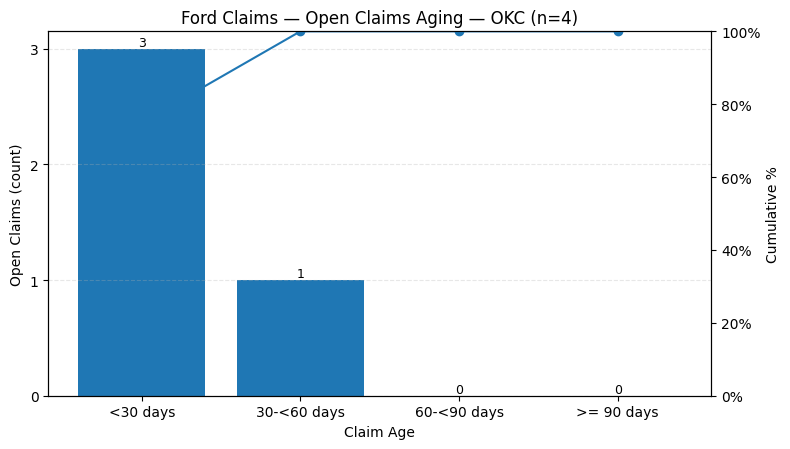

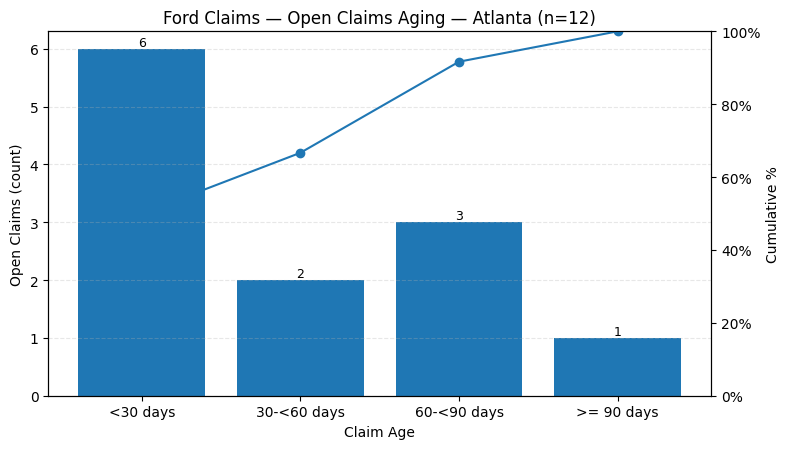

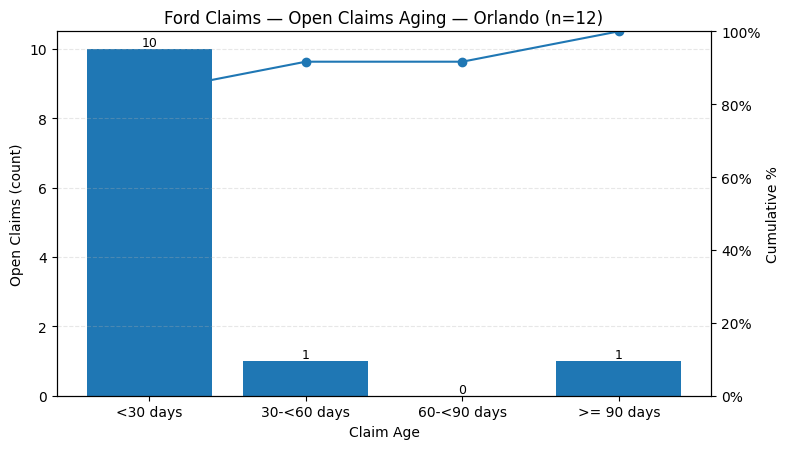

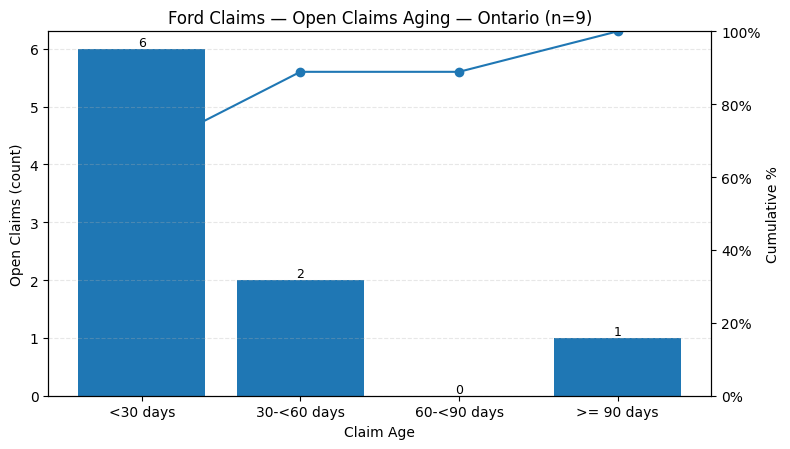

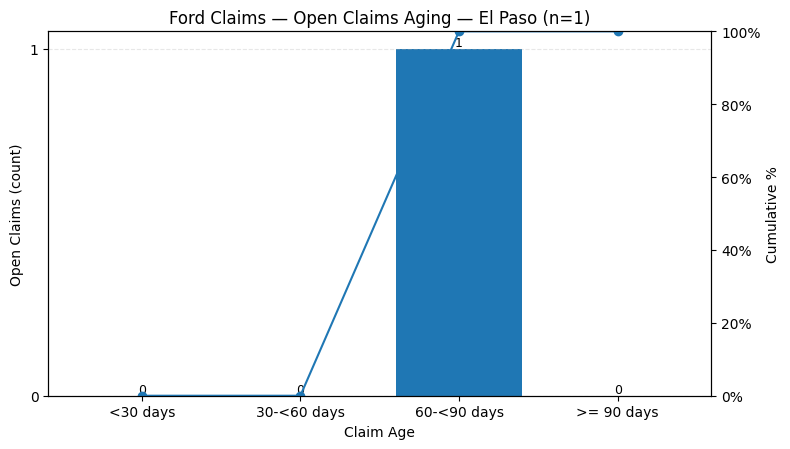

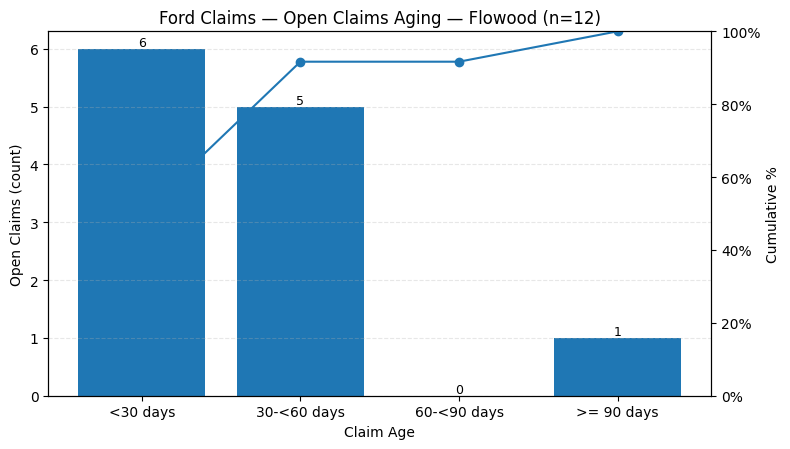

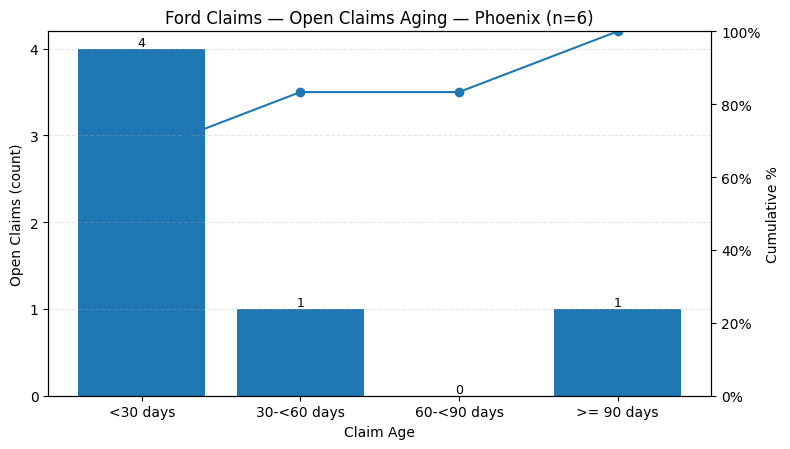

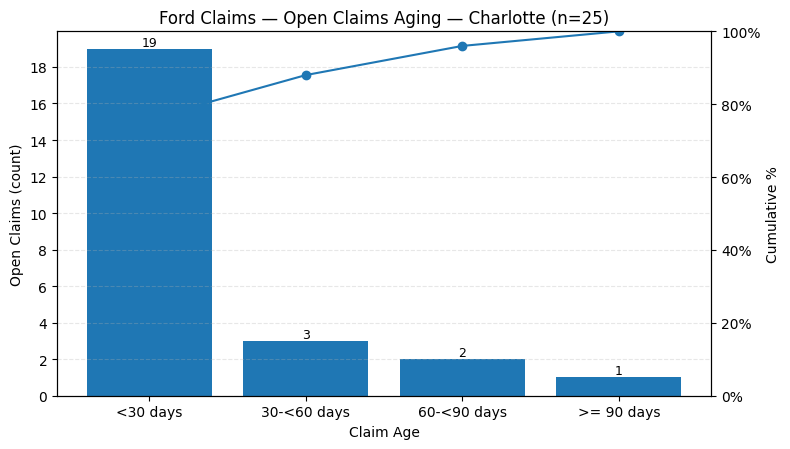

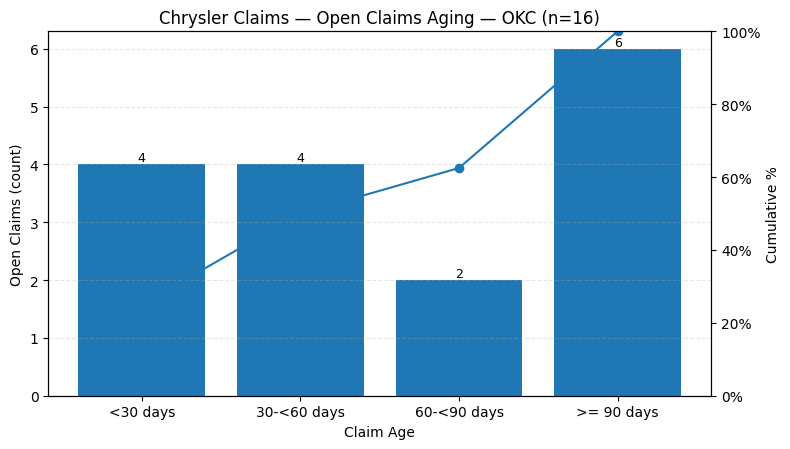

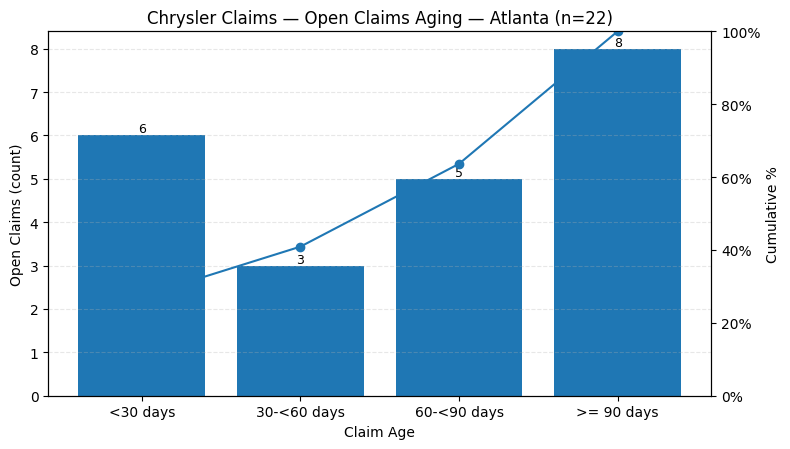

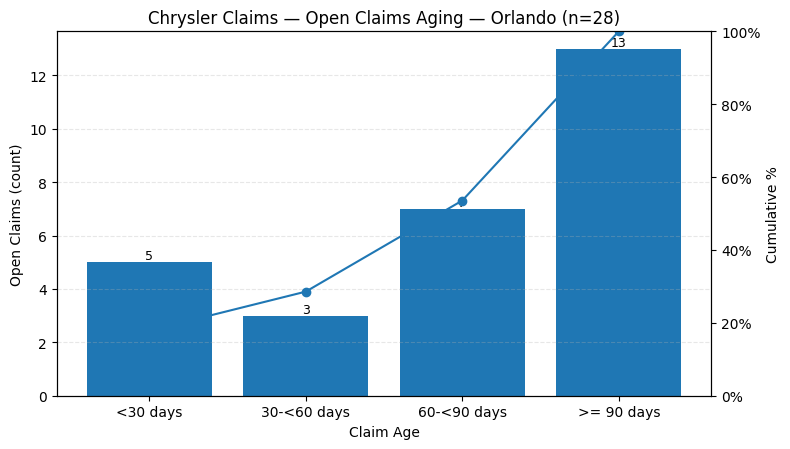

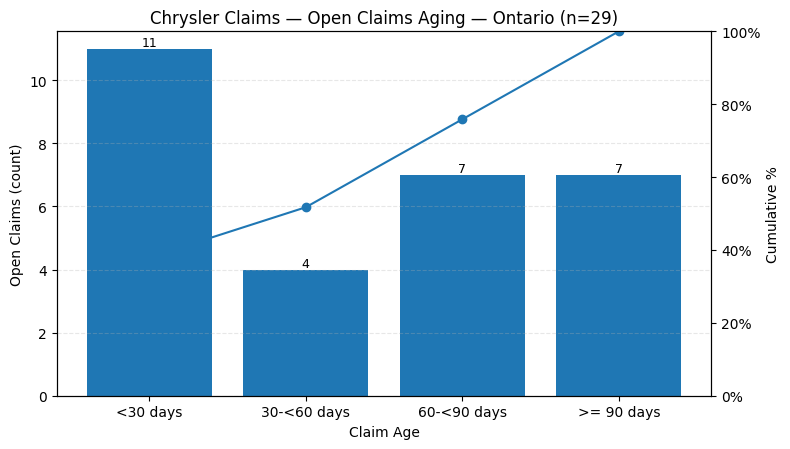

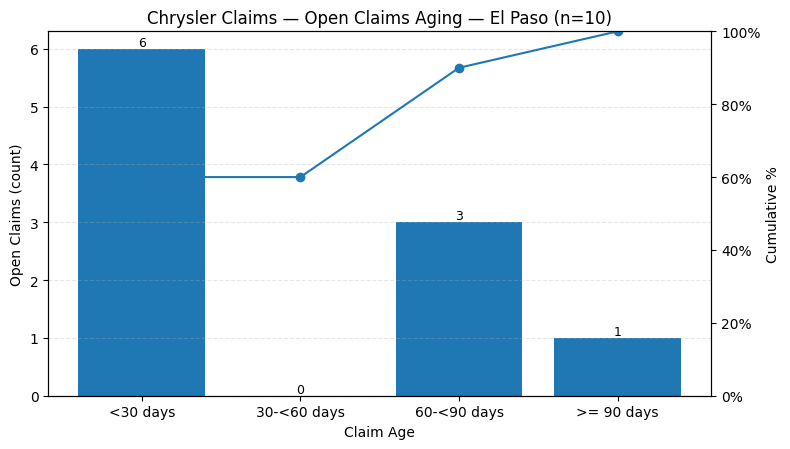

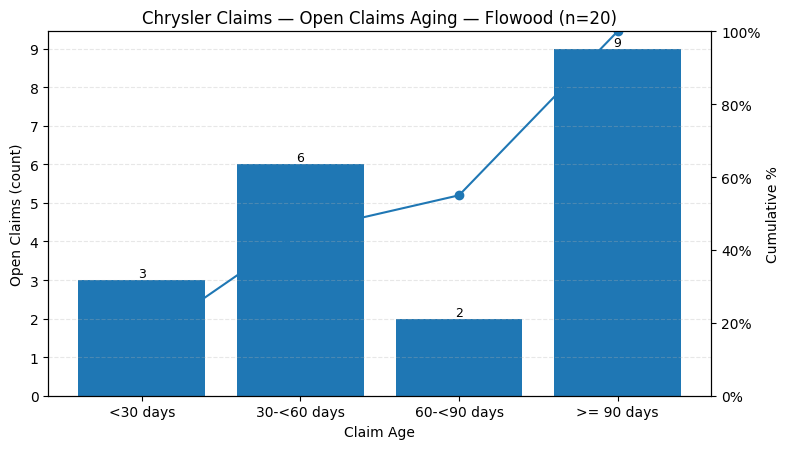

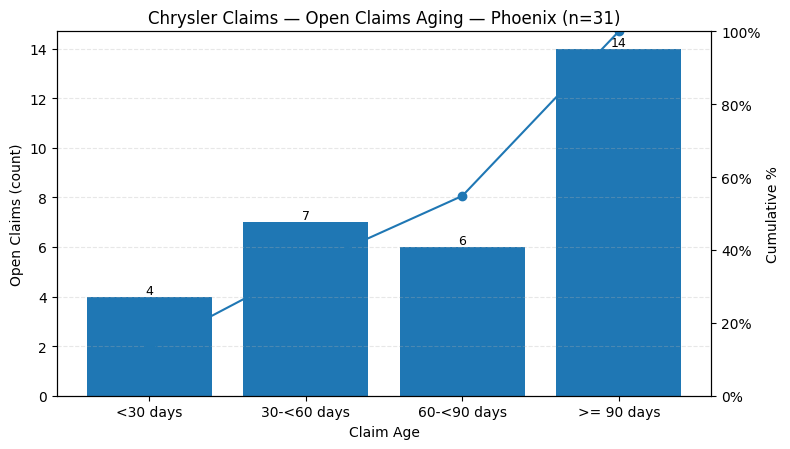

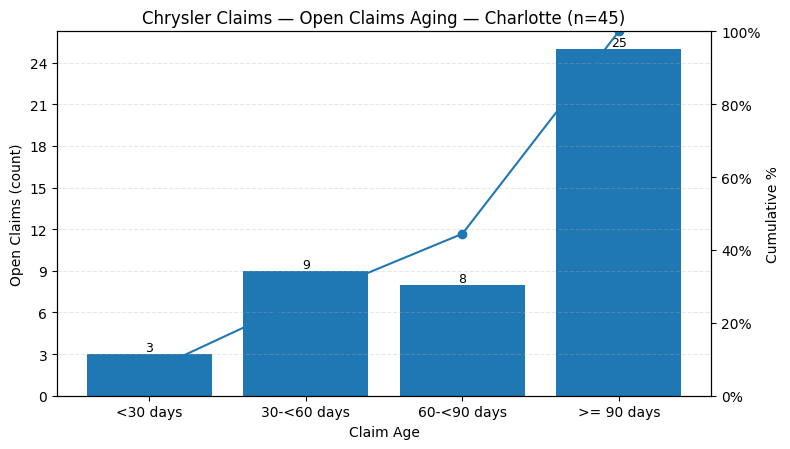

In [24]:
# ==== Generate Pareto charts per dataset & warehouse ====
if not aging_all.empty:
    order = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    for dname in aging_all["Dataset"].unique():
        sub_d = aging_all[aging_all["Dataset"] == dname]
        for wh in warehouses:
            wh_rows = sub_d[sub_d["Warehouse"] == wh]
            if wh_rows.empty:
                continue
            wh_rows = wh_rows.set_index("Aging Bucket").reindex(order).reset_index()
            plot_pareto_for_wh(wh_rows, dname, wh, max_labels=max_labels, save_dir=FIG_DIR)
else:
    print("No aging data to plot.")